<a href="https://colab.research.google.com/github/Hiago-Cavalcante/Projeto_IA/blob/main/Projeto_Final_IA_Hiago_Cavalcante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
import requests
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue
import threading
import random

In [296]:

class DotaAPICollector:
    def __init__(self, base_url="https://api.opendota.com/api", max_requests_per_minute=60, file_path="dota_matches.csv"):
        self.BASE_URL = base_url
        self.MAX_REQUESTS_PER_MINUTE = max_requests_per_minute
        self.processed_ids = set()
        self.lock = threading.Lock()
        self.file_path = file_path

    def make_request(self, endpoint, retries=3, backoff_factor=1):
        """Função genérica para fazer requisições com tratamento de erros."""
        url = f"{self.BASE_URL}/{endpoint}"
        for attempt in range(retries):
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    return response.json()
                elif response.status_code == 429:
                    wait_time = (2 ** attempt) * backoff_factor + random.uniform(1, 5)
                    print(f"Rate limit atingido. Tentativa {attempt + 1}/{retries}. Aguardando {wait_time:.2f}s...")
                    time.sleep(wait_time)
                elif response.status_code >= 500:
                    print(f"Erro 500 no servidor. Tentativa {attempt + 1}/{retries}.")
                    time.sleep(random.uniform(1, 5))
                else:
                    print(f"Erro ao acessar {url}: {response.status_code}")
                    return None
            except RequestException as e:
                print(f"Erro na requisição: {e}. Tentativa {attempt + 1}/{retries}.")
                time.sleep(random.uniform(1, 5))
        return None

    def get_public_match_ids(self, batch_size=100):
        matches = self.make_request("proMatches")
        if matches:
            return [match['match_id'] for match in matches[:batch_size]]
        return []

    def get_match_details(self, match_id):
        match_data = self.make_request(f"matches/{match_id}")
        if match_data:
            return {
                "Match_ID": match_id,
                "Radiant_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 0],
                "Dire_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 1],
                "Radiant_Win": match_data.get('radiant_win', False)
            }
        return None

    def save_to_csv(self, matches):
        df = pd.DataFrame(matches)
        if not df.empty:
            df.to_csv(self.file_path, mode='a', index=False, header=not pd.io.common.file_exists(self.file_path))
            print(f"{len(matches)} partidas salvas no arquivo.")

    def collect_matches(self, total_matches=1000, batch_size=100):
        while len(self.processed_ids) < total_matches:
            # Obter IDs de partidas
            match_ids = self.get_public_match_ids(batch_size)
            new_ids = [match_id for match_id in match_ids if match_id not in self.processed_ids]

            matches_data = []
            for match_id in new_ids:
                match_details = self.get_match_details(match_id)
                if match_details:
                    matches_data.append(match_details)
                    self.processed_ids.add(match_id)

                # Verifica se já coletou o total necessário
                if len(self.processed_ids) >= total_matches:
                    break

            self.save_to_csv(matches_data)
            print(f"Total coletado: {len(self.processed_ids)} / {total_matches}")

            # Sai do loop principal caso o total seja atingido
            if len(self.processed_ids) >= total_matches:
                print("Coleta concluída com sucesso.")
                break

            # Pausa para evitar rate limit
            print("Aguardando para evitar rate limit...")
            time.sleep(random.uniform(5, 10))


# Uso
if __name__ == "__main__":
    collector = DotaAPICollector()
    collector.collect_matches(total_matches=100, batch_size=100)



Rate limit atingido. Tentativa 1/3. Aguardando 4.08s...
Rate limit atingido. Tentativa 2/3. Aguardando 6.88s...
Rate limit atingido. Tentativa 3/3. Aguardando 5.63s...
Rate limit atingido. Tentativa 1/3. Aguardando 5.46s...
Rate limit atingido. Tentativa 2/3. Aguardando 4.56s...
Rate limit atingido. Tentativa 3/3. Aguardando 6.26s...
98 partidas salvas no arquivo.
Total coletado: 98 / 100
Aguardando para evitar rate limit...
2 partidas salvas no arquivo.
Total coletado: 100 / 100
Coleta concluída com sucesso.


In [297]:
df = pd.read_csv("dota_matches.csv")

# Visualizar as primeiras linhas
print(df.head())

# Obter informações sobre os dados
print(df.info())
print(df.describe())

     Match_ID                                     Radiant_Heroes  \
0  8066040823  [73, 110, 135, 49, 38, 94, 72, 119, 100, 63, 9...   
1  8066032611  [112, 110, 120, 88, 14, 9, 119, 2, 74, 136, 50...   
2  8065949434  [73, 49, 135, 25, 128, 86, 97, 22, 106, 41, 94...   
3  8065902119    [62, 90, 51, 45, 71, 61, 89, 20, 94, 1, 93, 74]   
4  8065853700   [73, 49, 97, 22, 19, 69, 45, 79, 72, 15, 95, 29]   

                                         Dire_Heroes  Radiant_Win  
0  [65, 77, 25, 51, 79, 84, 129, 128, 39, 13, 106...        False  
1  [79, 100, 21, 31, 105, 104, 51, 15, 19, 10, 46...        False  
2  [65, 77, 98, 110, 84, 69, 129, 100, 114, 95, 7...        False  
3  [38, 67, 88, 110, 79, 70, 84, 23, 25, 129, 35,...         True  
4  [110, 135, 74, 25, 51, 119, 65, 84, 77, 99, 12...        False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------------- 

In [298]:
import ast

# Converter as colunas para listas reais
df['Radiant_Heroes'] = df['Radiant_Heroes'].apply(ast.literal_eval)
df['Dire_Heroes'] = df['Dire_Heroes'].apply(ast.literal_eval)


In [299]:
print(df['Radiant_Win'].value_counts(normalize=True))


Radiant_Win
False    0.54
True     0.46
Name: proportion, dtype: float64


In [300]:
from collections import Counter

all_heroes = df['Radiant_Heroes'].explode().tolist() + df['Dire_Heroes'].explode().tolist()
hero_counts = Counter(all_heroes)
print(hero_counts.most_common(10))

[(110, 61), (51, 56), (74, 55), (97, 53), (25, 52), (88, 50), (112, 48), (86, 47), (84, 47), (49, 44)]


In [301]:
response = requests.get("https://api.opendota.com/api/heroes")
if response.status_code == 200:
    heroes = response.json()
    hero_map = {hero['id']: hero['localized_name'] for hero in heroes}

    hero_counts_named = [(hero_map[hero_id], count) for hero_id, count in hero_counts.most_common(10)]
    print(hero_counts_named)


[('Phoenix', 61), ('Clockwerk', 56), ('Invoker', 55), ('Magnus', 53), ('Lina', 52), ('Nyx Assassin', 50), ('Winter Wyvern', 48), ('Rubick', 47), ('Ogre Magi', 47), ('Dragon Knight', 44)]


In [302]:

# URL da API para obter heróis
heroes_url = "https://api.opendota.com/api/heroes"

# Fazer a requisição
response = requests.get(heroes_url)
if response.status_code == 200:
    heroes = response.json()
    hero_id_to_name = {hero['id']: hero['localized_name'] for hero in heroes}
    print("Mapeamento criado com sucesso!")
else:
    print(f"Erro ao acessar a API: {response.status_code}")


Mapeamento criado com sucesso!


In [303]:
print(hero_id_to_name)

{1: 'Anti-Mage', 2: 'Axe', 3: 'Bane', 4: 'Bloodseeker', 5: 'Crystal Maiden', 6: 'Drow Ranger', 7: 'Earthshaker', 8: 'Juggernaut', 9: 'Mirana', 10: 'Morphling', 11: 'Shadow Fiend', 12: 'Phantom Lancer', 13: 'Puck', 14: 'Pudge', 15: 'Razor', 16: 'Sand King', 17: 'Storm Spirit', 18: 'Sven', 19: 'Tiny', 20: 'Vengeful Spirit', 21: 'Windranger', 22: 'Zeus', 23: 'Kunkka', 25: 'Lina', 26: 'Lion', 27: 'Shadow Shaman', 28: 'Slardar', 29: 'Tidehunter', 30: 'Witch Doctor', 31: 'Lich', 32: 'Riki', 33: 'Enigma', 34: 'Tinker', 35: 'Sniper', 36: 'Necrophos', 37: 'Warlock', 38: 'Beastmaster', 39: 'Queen of Pain', 40: 'Venomancer', 41: 'Faceless Void', 42: 'Wraith King', 43: 'Death Prophet', 44: 'Phantom Assassin', 45: 'Pugna', 46: 'Templar Assassin', 47: 'Viper', 48: 'Luna', 49: 'Dragon Knight', 50: 'Dazzle', 51: 'Clockwerk', 52: 'Leshrac', 53: "Nature's Prophet", 54: 'Lifestealer', 55: 'Dark Seer', 56: 'Clinkz', 57: 'Omniknight', 58: 'Enchantress', 59: 'Huskar', 60: 'Night Stalker', 61: 'Broodmother',

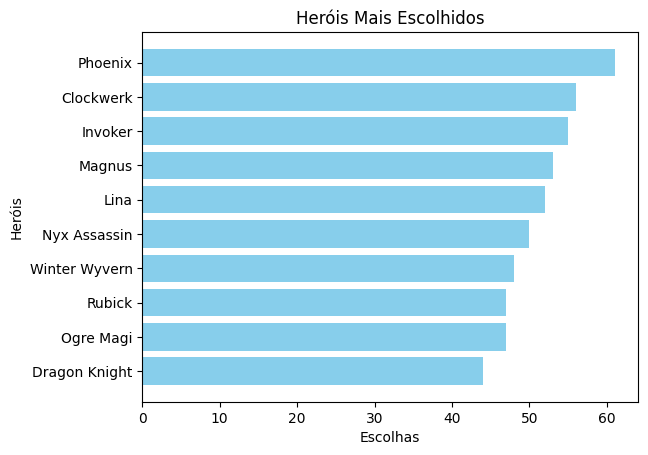

In [304]:
import matplotlib.pyplot as plt

heroes, counts = zip(*hero_counts_named)
plt.barh(heroes, counts, color='skyblue')
plt.xlabel('Escolhas')
plt.ylabel('Heróis')
plt.title('Heróis Mais Escolhidos')
plt.gca().invert_yaxis()
plt.show()


In [305]:
df_cleaned = df.dropna(subset=['Radiant_Heroes', 'Dire_Heroes'])

In [306]:
from collections import Counter

# Criar lista de todos os heróis para análise
all_heroes_radiant = df[df['Radiant_Win'] == True]['Radiant_Heroes'].explode()
all_heroes_dire = df[df['Radiant_Win'] == False]['Dire_Heroes'].explode()

# Calcular total de aparições
total_heroes = df['Radiant_Heroes'].explode().tolist() + df['Dire_Heroes'].explode().tolist()
total_counts = Counter(total_heroes)

# Contar vitórias
win_counts_radiant = Counter(all_heroes_radiant)
win_counts_dire = Counter(all_heroes_dire)

# Calcular taxa de vitória por herói
win_rates = {}
for hero_id in total_counts.keys():
    wins = win_counts_radiant.get(hero_id, 0) + win_counts_dire.get(hero_id, 0)
    total = total_counts[hero_id]
    win_rates[hero_id] = wins / total if total > 0 else 0

# Converter IDs para nomes (assumindo mapeamento hero_id_to_name)
win_rates_named = {hero_id_to_name.get(hero_id, hero_id): rate for hero_id, rate in win_rates.items()}

# Exibir resultados
print("Taxa de vitória dos heróis:")
for hero, win_rate in sorted(win_rates_named.items(), key=lambda x: x[1], reverse=True):
    print(f"{hero}: {win_rate:.2%}")



Taxa de vitória dos heróis:
Bloodseeker: 100.00%
Disruptor: 83.33%
Elder Titan: 80.00%
Warlock: 69.57%
Enigma: 68.75%
Shadow Shaman: 66.67%
Tinker: 66.67%
Oracle: 66.67%
Mars: 64.29%
Tusk: 63.64%
Broodmother: 62.50%
Slark: 62.50%
Primal Beast: 62.50%
Juggernaut: 62.50%
Nature's Prophet: 62.50%
Viper: 62.50%
Lich: 61.54%
Tiny: 61.11%
Visage: 61.11%
Muerta: 61.11%
Void Spirit: 60.87%
Invoker: 60.00%
Naga Siren: 60.00%
Monkey King: 60.00%
Huskar: 60.00%
Marci: 59.09%
Crystal Maiden: 58.33%
Sniper: 58.33%
Earth Spirit: 57.89%
Luna: 57.14%
Necrophos: 57.14%
Dawnbreaker: 56.52%
Mirana: 56.52%
Winter Wyvern: 56.25%
Lifestealer: 56.25%
Shadow Demon: 55.56%
Razor: 55.56%
Rubick: 55.32%
Pangolier: 55.00%
Bounty Hunter: 54.55%
Windranger: 54.55%
Ursa: 54.55%
Lone Druid: 54.55%
Storm Spirit: 54.17%
Pugna: 54.17%
Lina: 53.85%
Sand King: 53.85%
Bristleback: 53.57%
Techies: 53.33%
Ogre Magi: 53.19%
Lycan: 52.94%
Phoenix: 52.46%
Batrider: 52.00%
Queen of Pain: 51.72%
Doom: 51.28%
Shadow Fiend: 51.22%


In [307]:
# Filtrar taxas de vitória válidas
win_rates_cleaned = {hero: rate for hero, rate in win_rates_named.items() if rate > 0}


# Substituir 'nan' por 0 nas taxas de vitória
win_rates_named = {hero: (rate if not isinstance(rate, float) or not pd.isna(rate) else 0) for hero, rate in win_rates_named.items()}

# Exibir resultados sem 'nan'
print("Taxa de vitória dos heróis:")
for hero, win_rate in sorted(win_rates_named.items(), key=lambda x: x[1], reverse=True):
    if win_rate > 0:
        print(f"{hero}: {win_rate:.2%}")


Taxa de vitória dos heróis:
Bloodseeker: 100.00%
Disruptor: 83.33%
Elder Titan: 80.00%
Warlock: 69.57%
Enigma: 68.75%
Shadow Shaman: 66.67%
Tinker: 66.67%
Oracle: 66.67%
Mars: 64.29%
Tusk: 63.64%
Broodmother: 62.50%
Slark: 62.50%
Primal Beast: 62.50%
Juggernaut: 62.50%
Nature's Prophet: 62.50%
Viper: 62.50%
Lich: 61.54%
Tiny: 61.11%
Visage: 61.11%
Muerta: 61.11%
Void Spirit: 60.87%
Invoker: 60.00%
Naga Siren: 60.00%
Monkey King: 60.00%
Huskar: 60.00%
Marci: 59.09%
Crystal Maiden: 58.33%
Sniper: 58.33%
Earth Spirit: 57.89%
Luna: 57.14%
Necrophos: 57.14%
Dawnbreaker: 56.52%
Mirana: 56.52%
Winter Wyvern: 56.25%
Lifestealer: 56.25%
Shadow Demon: 55.56%
Razor: 55.56%
Rubick: 55.32%
Pangolier: 55.00%
Bounty Hunter: 54.55%
Windranger: 54.55%
Ursa: 54.55%
Lone Druid: 54.55%
Storm Spirit: 54.17%
Pugna: 54.17%
Lina: 53.85%
Sand King: 53.85%
Bristleback: 53.57%
Techies: 53.33%
Ogre Magi: 53.19%
Lycan: 52.94%
Phoenix: 52.46%
Batrider: 52.00%
Queen of Pain: 51.72%
Doom: 51.28%
Shadow Fiend: 51.22%


In [308]:
print(df.columns)


Index(['Match_ID', 'Radiant_Heroes', 'Dire_Heroes', 'Radiant_Win'], dtype='object')


In [321]:
from sklearn.preprocessing import MultiLabelBinarizer

# Codificar heróis escolhidos
mlb = MultiLabelBinarizer()
radiant_encoded = mlb.fit_transform(df['Radiant_Heroes'])
dire_encoded = mlb.transform(df['Dire_Heroes'])

# Criar DataFrame com heróis codificados
radiant_df = pd.DataFrame(radiant_encoded, columns=["Radiant_" + str(hero) for hero in mlb.classes_])
dire_df = pd.DataFrame(dire_encoded, columns=["Dire_" + str(hero) for hero in mlb.classes_])

# Combinar com o resultado da partida
model_df = pd.concat([radiant_df, dire_df, df['Radiant_Win']], axis=1)
print(model_df.head())

print(model_df.info())  # Informações sobre as colunas
print(model_df['Radiant_Win'].value_counts())  # Verificar balanceamento do target

# Features (heróis escolhidos)
X = model_df.drop(columns=['Radiant_Win'])

# Target (resultado da partida)
y = model_df['Radiant_Win']


   Radiant_1  Radiant_2  Radiant_3  Radiant_4  Radiant_5  Radiant_6  \
0          0          0          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          0          0          0   

   Radiant_7  Radiant_8  Radiant_9  Radiant_10  ...  Dire_121  Dire_123  \
0          0          0          0           0  ...         0         0   
1          0          0          1           0  ...         0         0   
2          0          0          0           0  ...         0         0   
3          0          0          0           0  ...         0         0   
4          0          0          0           0  ...         0         0   

   Dire_126  Dire_128  Dire_129  Dire_135  Dire_136  Dire_137  Dire_138  \
0         0         1         1         0      

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [108, 57, 59, 83] will be ignored
  warnings.warn(


In [310]:

print(model_df.info())  # Informações sobre as colunas
print(model_df['Radiant_Win'].value_counts())  # Verificar balanceamento do target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 101 entries, Radiant_97 to Radiant_Win
dtypes: bool(1), int64(100)
memory usage: 78.3 KB
None
Radiant_Win
False    54
True     46
Name: count, dtype: int64


In [311]:
# Features (heróis escolhidos)
X = model_df.drop(columns=['Radiant_Win'])

# Target (resultado da partida)
y = model_df['Radiant_Win']


In [322]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (80, 240)
Tamanho do conjunto de teste: (20, 240)


In [313]:
print(X.shape)

(100, 100)


In [325]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3
)

grid_search_rf.fit(X_train, y_train)

print(f"Melhores parâmetros para Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_



Melhores parâmetros para Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [327]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Criar o modelo de Regressão Logística
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Treinar o modelo
log_reg_model.fit(X_train, y_train)

# Fazer previsões
y_pred_log_reg = log_reg_model.predict(X_test)

# Avaliar o desempenho
print("Desempenho da Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_log_reg):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg))



Desempenho da Regressão Logística:
Acurácia: 0.40

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.40      0.67      0.50         9
        True       0.40      0.18      0.25        11

    accuracy                           0.40        20
   macro avg       0.40      0.42      0.38        20
weighted avg       0.40      0.40      0.36        20



In [328]:
from sklearn.ensemble import RandomForestClassifier

# Criar o modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliar o desempenho
print("Desempenho do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))



Desempenho do Random Forest:
Acurácia: 0.40

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.42      0.89      0.57         9
        True       0.00      0.00      0.00        11

    accuracy                           0.40        20
   macro avg       0.21      0.44      0.29        20
weighted avg       0.19      0.40      0.26        20



In [329]:
from sklearn.model_selection import cross_val_score

# Validação cruzada para Regressão Logística
log_reg_scores = cross_val_score(LogisticRegression(random_state=42, max_iter=1000), X, y, cv=5, scoring='accuracy')
print(f"Acurácia média (validação cruzada) - Regressão Logística: {log_reg_scores.mean():.2f}")

# Validação cruzada para Random Forest
rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=5, scoring='accuracy')
print(f"Acurácia média (validação cruzada) - Random Forest: {rf_scores.mean():.2f}")


Acurácia média (validação cruzada) - Regressão Logística: 0.46
Acurácia média (validação cruzada) - Random Forest: 0.48


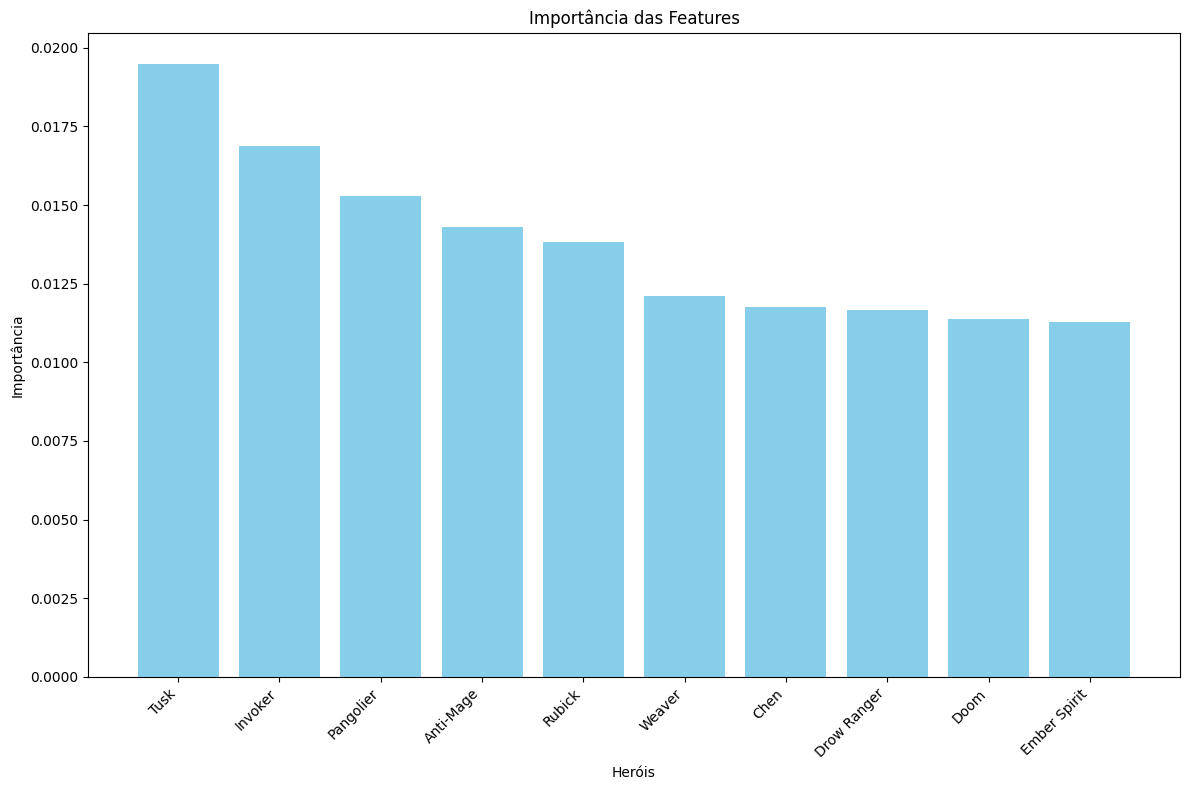

In [330]:
adjusted_feature_names = []
for col in X.columns:
    if "Radiant_" in col or "Dire_" in col:
        # Extrair o ID do herói do nome da coluna
        hero_id = int(col.split("_")[1])  # Extrai o número após "Radiant_" ou "Dire_"
        adjusted_feature_names.append(hero_id_to_name.get(hero_id, f"Hero_{hero_id}"))
    else:
        adjusted_feature_names.append(col)

# Importância das features no Random Forest
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

# Visualizar as 10 features mais importantes
plt.figure(figsize=(12, 8))
plt.title("Importância das Features")
plt.bar(range(10), importances[indices[:10]], align="center", color='skyblue')

# Nomes das features (heróis) no eixo X
plt.xticks(range(10), [adjusted_feature_names[i] for i in indices[:10]], rotation=45, ha="right")
plt.xlabel("Heróis")
plt.ylabel("Importância")
plt.tight_layout()
plt.show()



In [331]:
print(f"Acurácia no conjunto de treino: {log_reg_model.score(X_train, y_train):.2f}")
print(f"Acurácia no conjunto de teste: {log_reg_model.score(X_test, y_test):.2f}")


Acurácia no conjunto de treino: 1.00
Acurácia no conjunto de teste: 0.40


In [332]:
print(f"Acurácia no conjunto de treino: {rf_model.score(X_train, y_train):.2f}")
print(f"Acurácia no conjunto de teste: {rf_model.score(X_test, y_test):.2f}")


Acurácia no conjunto de treino: 1.00
Acurácia no conjunto de teste: 0.40
